In [16]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the Pytorch_Modules directory, download it from GitHub if it doesn't work
try:
    from Pytorch_Modules import engine, prediction, utils, alexnet
except:
    # Get the Pytorch_Modules scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/yasinahmadpoor/FromScratch
    !mv FromScratch/Pytorch_Modules .
    !rm -rf FromScratch
    from Pytorch_Modules import engine, prediction, utils


device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
def get_train_test_loader(data_dir,
                           batch_size,
                           augment,
                           shuffle=True):

    # define normalizer
    normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010])    # Normalize a tensor image with mean and standard deviation for n channels, this transform will normalize each channel of the input.


    # define transforms
    test_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),          # transforms.ToTensor() automatically scales the images to [0,1] range
                normalize])


    if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
    else:
            train_transform = transforms.Compose([
                transforms.Resize((227,227)),
                transforms.ToTensor(),
                normalize,
            ])

    # download and create datasets
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=test_transform, download=True)

    # define the data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = shuffle)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=shuffle)

    return (train_dataset, test_dataset, train_loader, test_loader)

BATCH_SIZE = 64
train_data, test_data, train_dataloader, test_dataloader = get_train_test_loader(data_dir = 'CIFAR10_data',
                                                    batch_size = BATCH_SIZE,
                                                    augment = False)
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Files already downloaded and verified
Files already downloaded and verified
Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ffa1160d6a0>, <torch.utils.data.dataloader.DataLoader object at 0x7ffa136aeaf0>)
Length of train dataloader: 782 batches of 64
Length of test dataloader: 157 batches of 64


In [3]:
# # Instantiate an instance of the model from the "alexnet.py" script
# torch.manual_seed(42)
# model = alexnet.AlexNet(input_channels=3,
#                         num_classes=10).to(device)

In [18]:
def set_AlexNet(NUM_CLASSES: int=10):
  # Set the manual seeds
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # Load pretrained model
  model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
  model.eval()

  # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
  for param in model.parameters():
    param.requires_grad = False

  num_ftrs = model.classifier[6].in_features  
  model.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)   # change number of output classes

  return model

In [19]:
# Print a summary using torchinfo (uncomment for actual output)
model = set_AlexNet()
summary(model=model, 
        input_size=(32, 3, 227, 227), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [32, 3, 227, 227]    [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 227, 227]    [32, 256, 6, 6]      --                   False
│    └─Conv2d (0)                        [32, 3, 227, 227]    [32, 64, 56, 56]     (23,296)             False
│    └─ReLU (1)                          [32, 64, 56, 56]     [32, 64, 56, 56]     --                   --
│    └─MaxPool2d (2)                     [32, 64, 56, 56]     [32, 64, 27, 27]     --                   --
│    └─Conv2d (3)                        [32, 64, 27, 27]     [32, 192, 27, 27]    (307,392)            False
│    └─ReLU (4)                          [32, 192, 27, 27]    [32, 192, 27, 27]    --                   --
│    └─MaxPool2d (5)                     [32, 192, 27, 27]    [32, 192, 13, 13]    --                   --
│    └─Conv2d (6

In [20]:
LEARNING_RATE = 0.005
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.005)

In [21]:
# Start training with help from engine.py
NUM_EPOCHS = 5
result = engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

09:34:04 --- Epoch: 1 | train_loss: 0.9443 | train_acc: 70.8660 | test_loss: 0.7279 | test_acc: 76.9208


0it [00:00, ?it/s]

0it [00:00, ?it/s]

09:36:17 --- Epoch: 2 | train_loss: 0.8523 | train_acc: 74.0589 | test_loss: 0.7916 | test_acc: 76.8014


0it [00:00, ?it/s]

0it [00:00, ?it/s]

09:38:31 --- Epoch: 3 | train_loss: 0.8000 | train_acc: 75.0180 | test_loss: 0.5810 | test_acc: 80.4737


0it [00:00, ?it/s]

0it [00:00, ?it/s]

09:40:45 --- Epoch: 4 | train_loss: 0.7963 | train_acc: 75.3976 | test_loss: 0.7574 | test_acc: 76.2241


0it [00:00, ?it/s]

0it [00:00, ?it/s]

09:43:01 --- Epoch: 5 | train_loss: 0.7967 | train_acc: 75.2318 | test_loss: 0.7051 | test_acc: 77.4084


In [ ]:
# # Save the model with help from utils.py
# utils.save_model(model=model,
#                  target_dir="models",
#                  model_name="05_going_modular_script_mode_tinyvgg_model.pth")

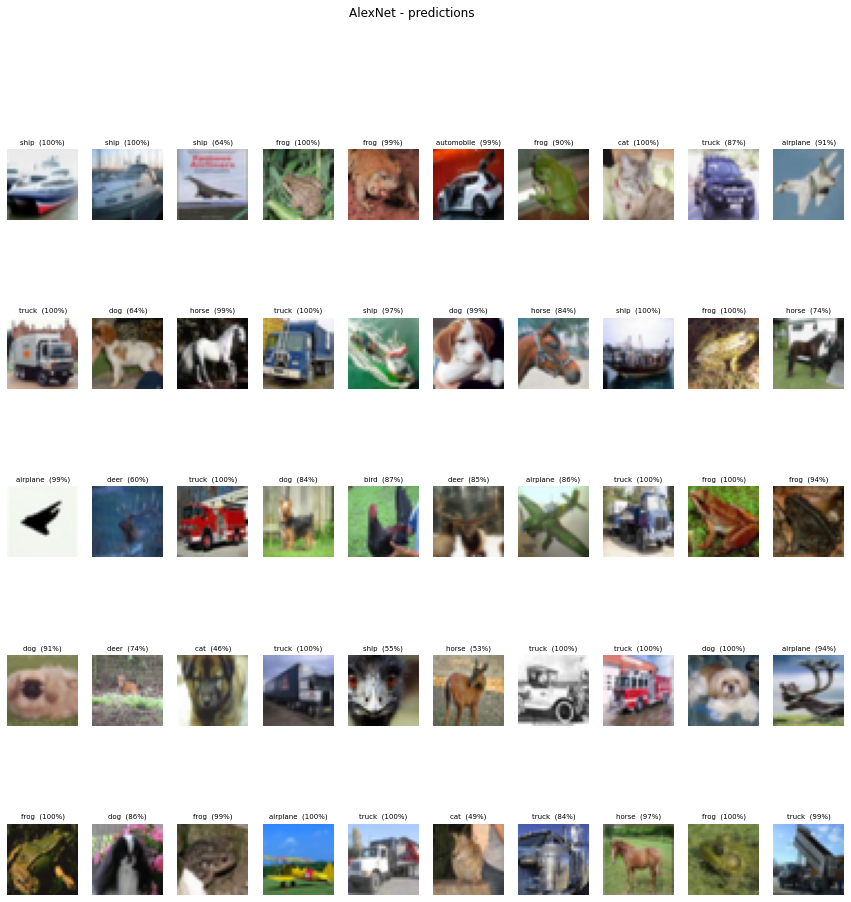

In [11]:
N_COLS = 10
N_ROWS = 5


fig = plt.figure(figsize=(15,15))
for index in range(1,  N_COLS* N_ROWS + 1):
    plt.subplot(N_ROWS, N_COLS, index)
    plt.axis('off')
    plt.imshow(test_data.data[index], cmap='gray_r')

    with torch.no_grad():
        model.eval()
        y_hat = model(test_data[index][0].unsqueeze(0).to(device))
        probs = torch.softmax(y_hat, dim=1)

    title = f'{train_data.classes[torch.argmax(probs).item()]}  ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=7)
fig.suptitle('AlexNet - predictions');
     

In [ ]:
# # Predicts on a target image with the model
# image_path = ''
# image_size = ''
# normalize = transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010]) 
# transform = transforms.Compose([
#             transforms.Resize((227,227)),
#             transforms.ToTensor(),          
#             normalize])
# prediction.pred_and_plot_image(model,
#                               train_data.class_names,
#                               image_path,
#                               image_size = [227,277],
#                               transform,
#                               device
#                               )